This notebook trains a model to mimic the behavior of the COMPAS recidivism classifier. The specific binary classification task for this model is to determine if a person belongs in the "Low" risk class according to COMPAS (negative class), or the "Medium" or "High" risk class (positive class).

In [4]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from google.colab import drive
import pickle

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [6]:
# Read data
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [7]:
#@title Preprocess the data

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race'])

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Female', 'sex_Male', 'age', 'race_African-American', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
#input_features = ['income_Lower', 'income_Higher', 'age', 'social-class_SC1', 'social-class_SC2', 'social-class_SC3', 'social-class_SC4', 'social-class_Other', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,recidivism_within_2_years,COMPASS_determination,sex_Female,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,69,0,0,0,0,0,0,0,1,0,0,0,0,1
1,34,0,0,0,0,1,0,0,1,1,0,0,0,0
2,24,0,0,1,4,1,0,0,1,1,0,0,0,0
3,23,0,1,0,1,0,1,0,1,1,0,0,0,0
4,43,0,0,0,2,0,0,0,1,0,0,0,0,1


In [8]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

In [9]:
#@title Regression model
# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2600      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13951 (54.50 KB)
Trainable params: 13951 (54.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Train the model
model.fit(train_data.values, train_labels.values, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
163/163 [==============================] - 2s 4ms/step - loss: 0.1929 - val_loss: 0.1718
Epoch 2/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1759 - val_loss: 0.1654
Epoch 3/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1718 - val_loss: 0.1640
Epoch 4/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1709 - val_loss: 0.1676
Epoch 5/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1709 - val_loss: 0.1624
Epoch 6/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1706 - val_loss: 0.1675
Epoch 7/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1708 - val_loss: 0.1608
Epoch 8/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1691 - val_loss: 0.1606
Epoch 9/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1687 - val_loss: 0.1621
Epoch 10/10
163/163 [==============================] - 1s 3ms/step - loss: 0.1683 - val_loss: 0.1611

In [11]:
# Predict on the validation set
predictions = model.predict(test_data.values)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_labels.values, predictions)

# Calculate Mean Squared Error
mse = mean_squared_error(test_labels.values, predictions)

# Calculate R^2 score
r2 = r2_score(test_labels.values, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

46/46 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.3509082930189656
Mean Squared Error: 0.1763437639380966
R^2 Score: 0.2914231178164497


In [12]:
#@title Binary Classification model
# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile the model with binary_crossentropy loss and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               2600      
                                                                 
 dense_5 (Dense)             (None, 50)                10050     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13951 (54.50 KB)
Trainable params: 13951 (54.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Train the model
history = model.fit(train_data.values, train_labels.values, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
163/163 [==============================] - 2s 4ms/step - loss: 0.5463 - accuracy: 0.7171 - val_loss: 0.5043 - val_accuracy: 0.7612
Epoch 2/10
163/163 [==============================] - 0s 3ms/step - loss: 0.5261 - accuracy: 0.7333 - val_loss: 0.4916 - val_accuracy: 0.7509
Epoch 3/10
163/163 [==============================] - 0s 3ms/step - loss: 0.5140 - accuracy: 0.7396 - val_loss: 0.4904 - val_accuracy: 0.7509
Epoch 4/10
163/163 [==============================] - 0s 3ms/step - loss: 0.5106 - accuracy: 0.7445 - val_loss: 0.5002 - val_accuracy: 0.7370
Epoch 5/10
163/163 [==============================] - 0s 3ms/step - loss: 0.5081 - accuracy: 0.7474 - val_loss: 0.4895 - val_accuracy: 0.7664
Epoch 6/10
163/163 [==============================] - 0s 2ms/step - loss: 0.5087 - accuracy: 0.7456 - val_loss: 0.4952 - val_accuracy: 0.7526
Epoch 7/10
163/163 [==============================] - 0s 2ms/step - loss: 0.5096 - accuracy: 0.7433 - val_loss: 0.4907 - val_accuracy: 0.7595
Epoch 

In [14]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data.values, test_labels.values)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for test data
test_predictions = model.predict(test_data.values)
test_predictions_rounded = test_predictions.round()

# Calculate precision and recall
precision = precision_score(test_labels.values, test_predictions_rounded)
recall = recall_score(test_labels.values, test_predictions_rounded)

print("Test Precision:", precision)
print("Test Recall:", recall)

# Calculate train metrics
train_predictions = model.predict(train_data.values)
train_predictions_rounded = train_predictions.round()

train_accuracy = accuracy_score(train_labels.values, train_predictions_rounded)
train_precision = precision_score(train_labels.values, train_predictions_rounded)
train_recall = recall_score(train_labels.values, train_predictions_rounded)

print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)

46/46 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.7152
Test Loss: 0.542853593826294
Test Accuracy: 0.7151767015457153
46/46 [==============================] - 0s 2ms/step
Test Precision: 0.6666666666666666
Test Recall: 0.7786032689450223
181/181 [==============================] - 0s 2ms/step
Train Accuracy: 0.7347080228729856
Train Precision: 0.6798061389337642
Train Recall: 0.7957639939485628


# SHAP MODEL EVALUTAION

On the following dataset, we aimed to apply a classification model to analyze how the COMPAS model makes decisions. Indeed, we trained the chosen model using the output of the COMPAS classification model as the target variable. Therefore, following a recreation of the COMPAS prediction model, our objective is to evaluate if there is a bias component in the decision-making process. To do this, we apply the Shap method to the chosen model.

In [59]:
! pip install shap
import shap


explainer = shap.DeepExplainer(model, test_data.values)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [60]:
shap_values = explainer.shap_values(test_data.values)

print(explainer.expected_value)
shap.initjs()

shap.force_plot(np.array(explainer.expected_value), shap_values[0], test_data, link='logit')

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


tf.Tensor([0.5393302], shape=(1,), dtype=float32)


In the analysis of the force plot, it's evident how the variables that contribute most to the prediction are age, priors count, and race. We can see that as age increases, the values of the shape values decrease, meaning that the model tends to lower the probability of recidivism as age increases. Regarding the priors count variable, the model increases the probability of recidivism as the variable increases, as the shape values increase. The most interesting result concerns the race variable. We can see how, compared to all observations, a person's race significantly contributes to the prediction of the probability. Indeed, by scrolling through the graph, we can see how being African American is associated with positive shapley values, while being white negatively contributes to the probability of recidivism. Consequently, the model tends to increase the probability of recidivism if the inmate is African American, while it tends to decrease it if they belong to another race. Therefore, we can start hypothesizing the presence of bias.

In [61]:

shap.initjs()
shap.force_plot(np.array(explainer.expected_value), shap_values[0][100], test_data.iloc[100], link='logit')


Analyzing this prediction, we can observe how not being African American has contributed to lowering the predicted probability, as well as belonging to the 'Other' race category. Therefore, we can say that in this case, the model has discriminated based on race. In addition, we can also see that being male has contributed to increasing the predicted probability of recidivism.

Let's analyze the shapley values for an offenders predicted as positive and afro american

In [93]:

shap.initjs()

positive_african_american_indices = []
for i in range(len(test_predictions_rounded)):
    if test_predictions_rounded[i] == 1 and test_data.iloc[i]['race_African-American']==1:
        positive_african_american_indices.append(i)

shap.force_plot(np.array(explainer.expected_value), shap_values[0][positive_african_american_indices[2]], test_data.iloc[positive_african_american_indices[2]])



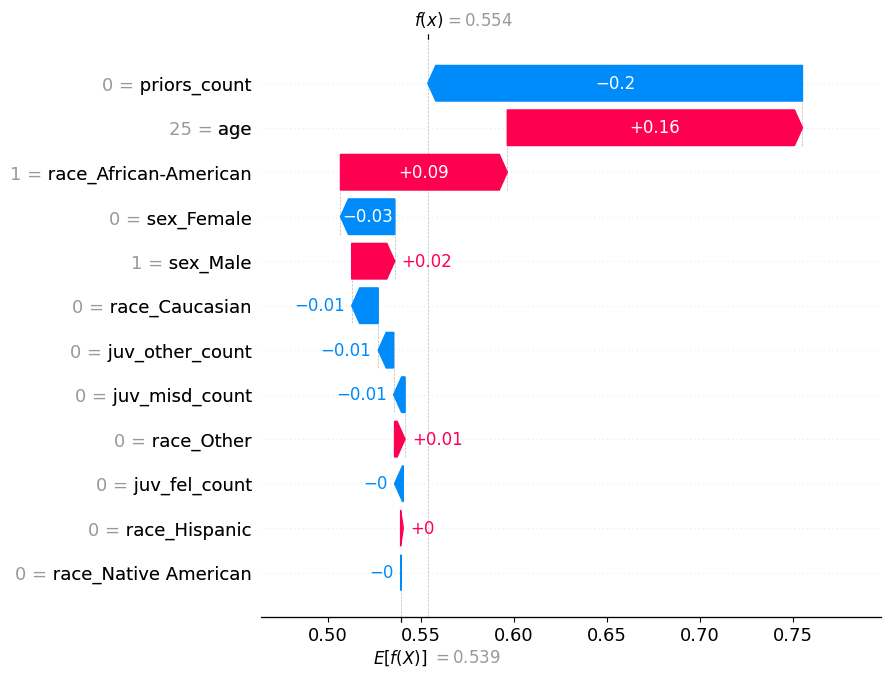

In [94]:
#Plots bar

shap_explanation = shap.Explanation(
    values=shap_values[0][positive_african_american_indices[2]],  # Assicurati che shap_values[1] contenga i valori SHAP per la classe di interesse
    base_values=np.array(explainer.expected_value),  # Valore atteso per la classe di interesse
    data=test_data.iloc[positive_african_american_indices[2]],  # Dati dell'istanza
    feature_names=test_data.columns  # Nomi delle feature
)
shap.plots.waterfall(shap_explanation, max_display=14)

We can see that in the prediction of the probability of recidivism, the model has raised the predicted probability compared to the fact that the inmate was African American. Indeed the fact of being African contributed on average to an increase of 0.09 in the probability of recidivism compared to the average predicted probability. Let's analyze whether a not African American person with the same number or higher number of prior offenses and the same age or lower age was assigned as not risky.

In [98]:

shap.initjs()
indices_matching_criteria = []
for i in range(len(test_predictions_rounded)):
    if test_predictions_rounded[i] == 0 and test_data.iloc[i]['age'] <= 25 and test_data.iloc[i]['priors_count'] >= 0 and test_data.iloc[i]['race_African-American'] == 0 and test_data.iloc[i]['sex_Female'] == 0 :
        indices_matching_criteria.append(i)


shap.force_plot(np.array(explainer.expected_value), shap_values[0][indices_matching_criteria[0]], test_data.iloc[indices_matching_criteria[0]])


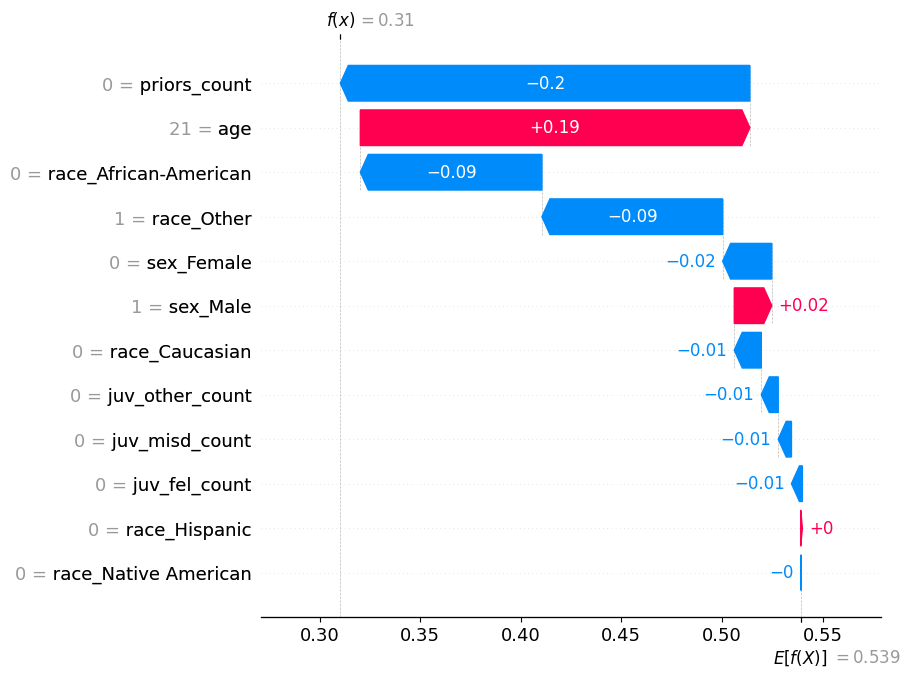

In [97]:
#Plots bar

shap_explanation = shap.Explanation(
    values=shap_values[0][indices_matching_criteria[0]],  # Assicurati che shap_values[1] contenga i valori SHAP per la classe di interesse
    base_values=np.array(explainer.expected_value),  # Valore atteso per la classe di interesse
    data=test_data.iloc[indices_matching_criteria[0]],  # Dati dell'istanza
    feature_names=test_data.columns  # Nomi delle feature
)
shap.plots.waterfall(shap_explanation, max_display=14)


We can see that this inmate was classified as negative, despite being younger (and we know that age is indirectly proportional to the probability of recidivism) and having the same number of priors_count, largely because not being African American contributed to lowering the predicted probability.


tf.Tensor([0.5393302], shape=(1,), dtype=float32)


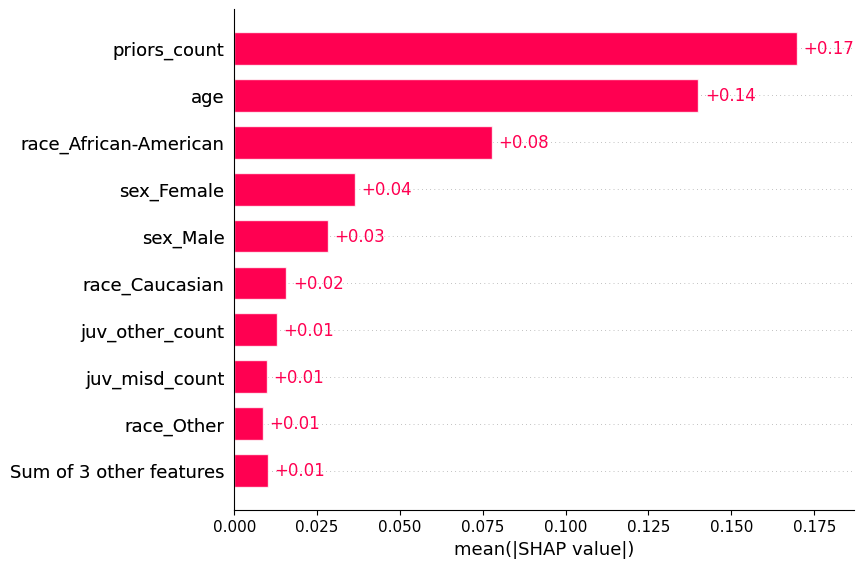

In [79]:

test_shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=np.array([explainer.expected_value]),
    data=test_data.values,
    feature_names=test_data.columns
)
print(explainer.expected_value)
shap.plots.bar(test_shap_explanation, max_display=10)

From this plot we can see for each variable the average of its shap values. It becomes evident that the primary influential features are the count of prior convictions, the age of the individual, and their membership in the Afro-American demographic category. Consequently, our predictive model typically increases the probability by 0.08 points compared to the average forecast when the individual is identified as African American.

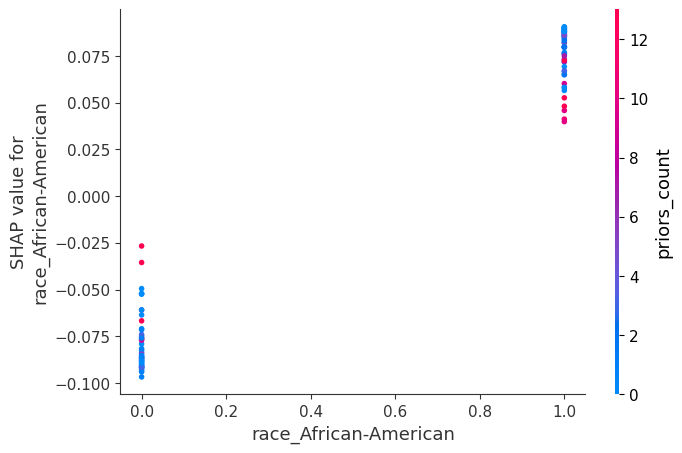

In [76]:
shap.dependence_plot('race_African-American', shap_values[0][:100], test_data.iloc[:100])

It's evident how being African American contributes to the increase in the predicted probability of recidivism; in fact, if you have the same number of priors count, for the model, not being African American lowers your predicted probability, while being African American raises it.

Let's analyse globally all the features:

(1443, 12) (1443, 12)


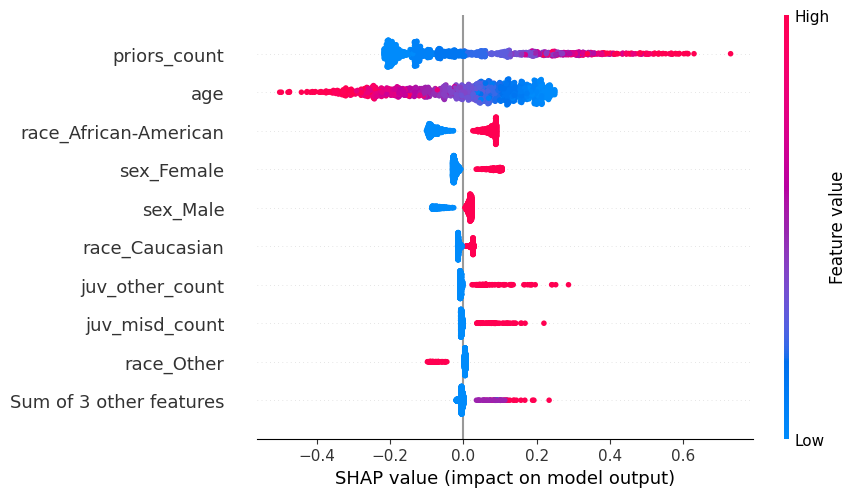

In [86]:
shap.plots.beeswarm(test_shap_explanation)


We can conclude that, by analyzing the results of SHAP, there is a racist bias component present in our context